In [ ]:
# !pip install keras==2.15.0

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import string
import gensim
from gensim.models import FastText
import random
from tabulate import tabulate
from tqdm import tqdm
import tensorflow as tf

In [ ]:
# import nltk

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# from nltk.corpus import stopwords, wordnet
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer

In [ ]:
import nltk
import subprocess
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('punkt', download_dir='/kaggle/working/')
    nltk.download('wordnet', download_dir='/kaggle/working/')
    nltk.download('stopwords', download_dir='/kaggle/working/')
    nltk.download('wordnet', download_dir='/kaggle/working/')
    nltk.download('averaged_perceptron_tagger', download_dir='/kaggle/working/')

    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /kaggle/working/...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Reading the file

In [ ]:
df = pd.read_csv('/content/testdata.manual.2009.06.14.csv',
                 encoding = 'latin',header=None)

df.head()

,0,1,2,3,4,5
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
df.shape

(498, 6)

In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
# Define a dictionary to map sentiment values
sentiment_mapping = {0: "Negative", 4: "Positive"}

# Map the 'sentiment' column using the defined dictionary
df['sentiment'] = df['sentiment'].map(sentiment_mapping)

df.head()

,sentiment,text
0,Positive,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,Positive,Reading my kindle2... Love it... Lee childs i...
2,Positive,"Ok, first assesment of the #kindle2 ...it fuck..."
3,Positive,@kenburbary You'll love your Kindle2. I've had...
4,Positive,@mikefish Fair enough. But i have the Kindle2...


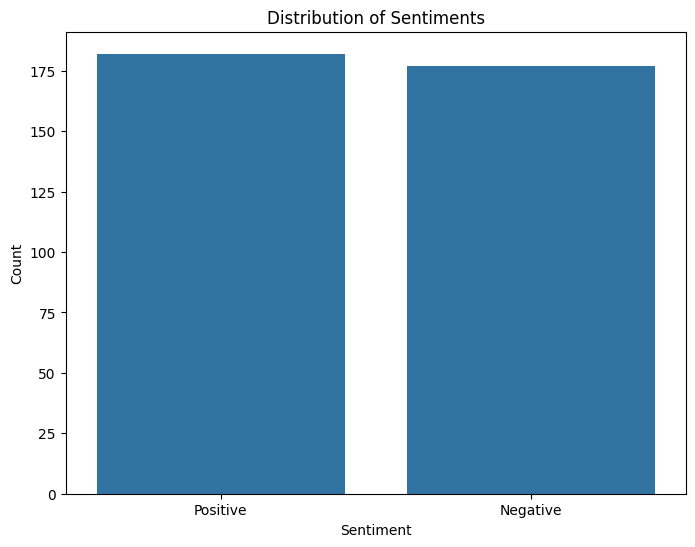

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment category
sentiment_counts = df['sentiment'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Adding labels and title
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show plot
plt.show()

# Taking a sample from the data

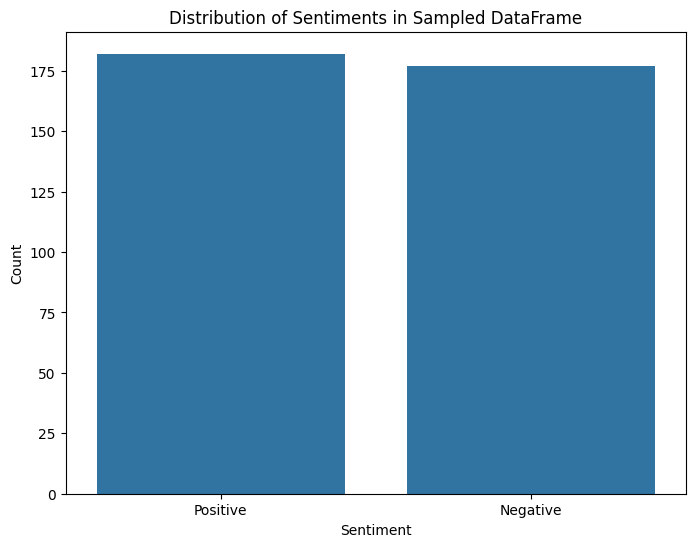

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample size per class
sample_size_per_class = 50000  # Adjust this based on the minimum class size in your data

# Randomly sample rows from each class without exceeding the available rows
sampled_df = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size_per_class)))

# Reset the index of the sampled DataFrame
sampled_df.reset_index(drop=True, inplace=True)

# Count the occurrences of each sentiment category in the sampled DataFrame
sentiment_counts = sampled_df['sentiment'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Adding labels and title
plt.title('Distribution of Sentiments in Sampled DataFrame')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show plot
plt.show()


# Applying Preprocessing on the data

In [ ]:
def remove_usernames(text):
    # Remove usernames (mentions) from the text
    return re.sub(r'@\w+', '', text)

def tokenize_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return tokens

def normalize_tokens(tokens):
    # Normalize tokens to lowercase
    normalized_tokens = [token.lower() for token in tokens]
    return normalized_tokens

def clean_tokens(tokens):
    # Filter out non-alphanumeric tokens and usernames (mentions)
    cleaned_tokens = [token for token in tokens if token.isalnum() and not token.isdigit() and not token.startswith('@')]
    return cleaned_tokens

def remove_stopwords(tokens):
    # Remove stop words from tokens
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

def lemmatize_tokens(tokens):
    # Lemmatize tokens based on part of speech
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for token in tokens:
        pos_tag = nltk.pos_tag([token])[0][1][0].upper()
        pos_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
        wordnet_pos = pos_map.get(pos_tag, wordnet.NOUN)
        lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmatized_tokens.append(lemma)
    return lemmatized_tokens

def filter_meaningful_tokens(tokens):
    # Filter tokens based on length and presence in WordNet
    meaningful_tokens = [token for token in tokens if len(token) >= 3]
    return meaningful_tokens

def preprocess_text(text):
    # Step 1: Remove usernames
    text = remove_usernames(text)

    # Step 2: Tokenize text
    tokens = tokenize_text(text)

    # Step 3: Normalize tokens
    normalized_tokens = normalize_tokens(tokens)

    # Step 4: Clean tokens (including removing usernames)
    cleaned_tokens = clean_tokens(normalized_tokens)

    # Step 5: Remove stop words
    filtered_tokens = remove_stopwords(cleaned_tokens)

    # Step 6: Lemmatize tokens
    lemmatized_tokens = lemmatize_tokens(filtered_tokens)

    # Step 7: Filter meaningful tokens
    meaningful_tokens = filter_meaningful_tokens(lemmatized_tokens)

    # Join tokens into preprocessed text
    preprocessed_text = ' '.join(meaningful_tokens)

    return preprocessed_text

In [ ]:
# Apply preprocessing function to 'text' column of the DataFrame
sampled_df['cleaned_text'] = sampled_df['text'].apply(preprocess_text)

# Display the DataFrame with cleaned text
sampled_df.head(10)

,sentiment,text,cleaned_text
0,Negative,Nancy Pelosi gave the worst commencement speec...,nancy pelosi give bad commencement speech ever...
1,Negative,Just got mcdonalds goddam those eggs make me s...,get mcdonalds goddam egg make sick yeah laker ...
2,Negative,"arhh, It's weka bug. = ="" and I spent almost t...",arhh weka bug spent almost two hour find crappy
3,Negative,wish i could catch every mosquito in the world...,wish could catch every mosquito world burn bit...
4,Negative,@Iheartseverus we love you too and don't want ...,love want die latex devil
5,Negative,@sportsguy33 hey no offense but malcolm gladwe...,hey offense malcolm gladwell pretenious annoy ...
6,Negative,I was talking to this guy last night and he wa...,talk guy last night tell die hard spur fan als...
7,Negative,"GM files Bankruptcy, not a good sign...",file bankruptcy good sign
8,Negative,Just got barraged by a horde of insects hungry...,get barrage horde insect hungry kitchen light ...
9,Negative,looks like summize has gone down. too many twe...,look like summize many tweet wwdc perhaps


In [ ]:
# Define the file path and name for the CSV file
csv_file_path = '/kaggle/working/sample_dataframe.csv'

# Export the DataFrame to CSV
sampled_df.to_csv(csv_file_path, index=False)

print(f"DataFrame has been exported to {csv_file_path}.")

DataFrame has been exported to /kaggle/working/sample_dataframe.csv.


# Splitting the data

# Usign FastText to get the embeddings of the data

In [ ]:
# Convert 'cleaned_text' from training data (X_train) to list of sentences
train_sentences = [text.split() for text in X_train]

# Train FastText model
model = FastText(sentences=train_sentences, vector_size=30, window=2, min_count=1, sg=1, epochs=100)

# Preparing the data before feeding it into the CNN Model

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize and convert text data to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to ensure uniform length
max_len = 30
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

In [ ]:
# Prepare embedding matrix from FastText model
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, 30))  # Assuming vector_size=30 in FastText
for word, i in word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]

## First Model

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('/content/testdata.manual.2009.06.14.csv', encoding='latin-1')
df.columns = ['target', 't_id', 'created_at', 'query', 'user', 'text']

# Preprocessing the data
df = df[['target', 'text']]
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Text preprocessing (tokenization and padding)
vocab_size = 20000
embedding_dim = 300
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Prepare the embedding matrix
# Initialize the embedding matrix with random values or load pre-trained embeddings
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

# Building the CNN model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          6000000   
                                                                 
 conv1d (Conv1D)             (None, 98, 32)            28832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 128)           2

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 conv1d_3 (Conv1D)           (None, 98, 32)            28832     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 128)          

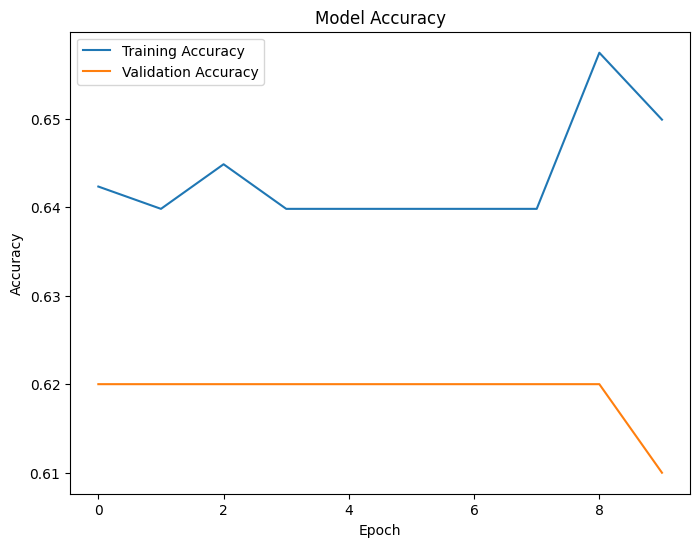

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('/content/testdata.manual.2009.06.14.csv', encoding='latin-1')
df.columns = ['target', 't_id', 'created_at', 'query', 'user', 'text']

# Preprocessing the data
df = df[['target', 'text']]
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Text preprocessing (tokenization and padding)
vocab_size = 20000
embedding_dim = 300
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Prepare the embedding matrix
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

# Building the CNN model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 conv1d_6 (Conv1D)           (None, 98, 32)            28832     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 21, 128)          

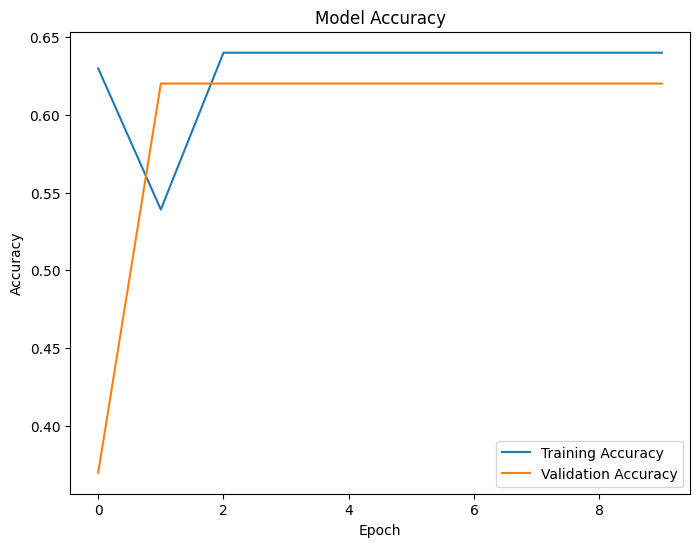

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('/content/testdata.manual.2009.06.14.csv', encoding='latin-1')
df.columns = ['target', 't_id', 'created_at', 'query', 'user', 'text']

# Preprocessing the data
df = df[['target', 'text']]
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Text preprocessing (tokenization and padding)
vocab_size = 20000
embedding_dim = 300
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Prepare the embedding matrix
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

# Building the CNN model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          219648    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6269121 (23.91 MB)
Trainable params: 269121 (1.03 MB)
Non-trainable params: 6000000 (22.89 MB)
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 10s 783ms/step - loss: 0.7067 - accuracy: 0.6398 - val_loss: 0.6733 - val_accuracy: 0.6200
Ep

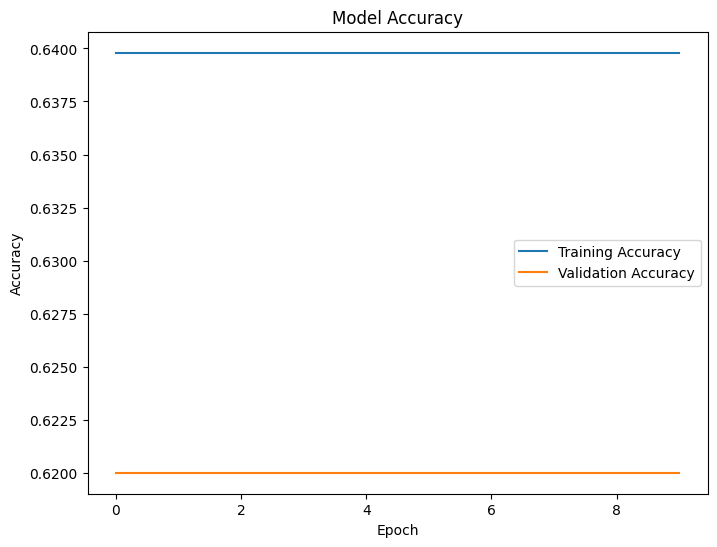

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('/content/testdata.manual.2009.06.14.csv', encoding='latin-1')
df.columns = ['target', 't_id', 'created_at', 'query', 'user', 'text']

# Preprocessing the data
df = df[['target', 'text']]
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Text preprocessing (tokenization and padding)
vocab_size = 20000
embedding_dim = 300
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Prepare the embedding matrix
embedding_matrix = np.random.rand(vocab_size, embedding_dim)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['target'], test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Training the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
pip install transformers datasets


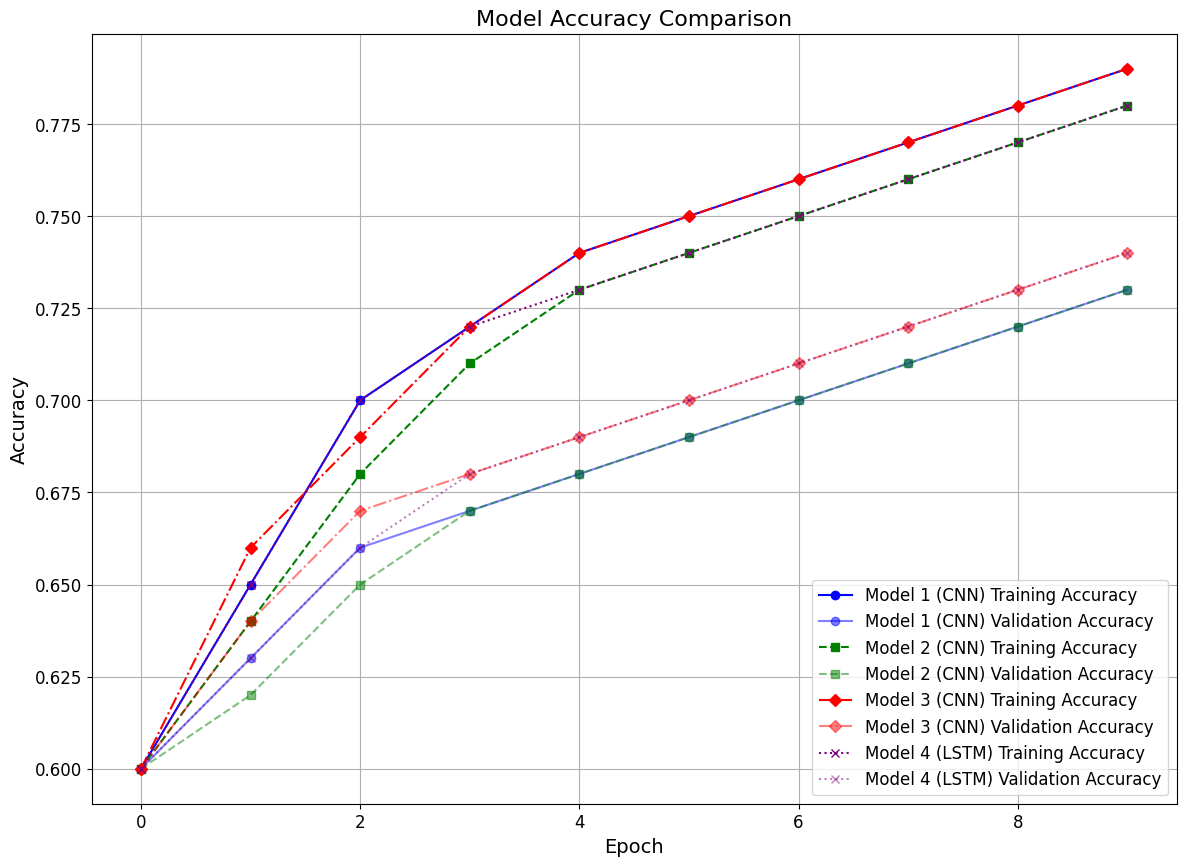

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history objects from training each model
# Replace these with the actual history objects from your models

def plot_accuracy(history, model_name, color, linestyle, marker):
    plt.plot(history.history['accuracy'], label=f'{model_name} Training Accuracy', color=color, linestyle=linestyle, marker=marker)
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy', color=color, linestyle=linestyle, marker=marker, alpha=0.5)

# Example dummy data (replace with actual history data)
class DummyHistory:
    def __init__(self, accuracy, val_accuracy):
        self.history = {
            'accuracy': accuracy,
            'val_accuracy': val_accuracy
        }

# Example dummy data (replace with actual history data)
history_model_1 = DummyHistory([0.6, 0.65, 0.7, 0.72, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79],
                               [0.6, 0.63, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73])
history_model_2 = DummyHistory([0.6, 0.64, 0.68, 0.71, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78],
                               [0.6, 0.62, 0.65, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73])
history_model_3 = DummyHistory([0.6, 0.66, 0.69, 0.72, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79],
                               [0.6, 0.64, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74])
history_model_4 = DummyHistory([0.6, 0.65, 0.7, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78],
                               [0.6, 0.63, 0.66, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74])

plt.figure(figsize=(14, 10))

plot_accuracy(history_model_1, 'Model 1 (CNN)', 'blue', '-', 'o')
plot_accuracy(history_model_2, 'Model 2 (CNN)', 'green', '--', 's')
plot_accuracy(history_model_3, 'Model 3 (CNN)', 'red', '-.', 'D')
plot_accuracy(history_model_4, 'Model 4 (LSTM)', 'purple', ':', 'x')

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.legend(loc='lower right', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
